In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True) # Seaborn desaturates matplotlib colors (this is useful if you use both seaborn and basic matplot lib and want colors to be consistent)
import scipy.stats as stats
sns.set(palette='husl', context = 'talk', style='white', font_scale=1)

import os
import scikit_posthocs as sp
from pybedtools import BedTool
import pybedtools
from upsetplot import plot, from_indicators
import pysam
import json
import re
import random


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU

import tensorflow as tf
print(tf.__version__)
if tf.__version__[0] == '1':
    tf.compat.v1.enable_eager_execution()
from basenji import dataset, dna_io, seqnn
np.random.seed(1337)

2023-03-31 15:43:57.790272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


In [3]:
BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level


#Wynton
BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data 
RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results

SRC_PATH = os.path.join(BASE_PATH, "src")  # where any packages needed to run analyses live. I haven't started structuring things this way yet. 

COMP_PATH = os.path.join(DATA_PATH,"pairwise/hsmrca")
COMP_PATH = os.path.join(DATA_PATH,"pairwise/reference")


# Local

# DATA_PATH = os.path.join(BASE_PATH, "../../../dowloads/")  # where I dump new data
# COMP_PATH = os.path.join(DATA_PATH,"1KGvsHSMRCA")

In [4]:
BASE_PATH

'/wynton/group/capra/projects/modern_human_3Dgenome'

In [5]:
FASTA_PATH = os.path.join(DATA_PATH, "genomes")

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
MODEL_DIR = '%s/basenji/manuscripts/akita/' % BIN_PATH
AKITA_PARAMS = 'params.json'

MODEL = 'model_best.h5'

TARGETS = "targets.txt"

STATS = "statistics.json"


In [8]:
#Setting up Akita model
### load params, specify model ###
print('load params and model')
params_file = os.path.join(MODEL_DIR, AKITA_PARAMS)
model_file  = os.path.join(MODEL_DIR, MODEL)
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']

seqnn_model = seqnn.SeqNN(params_model)

### restore model ###
print('restore model')
seqnn_model.restore(model_file)

load params and model
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-31 15:44:27.689532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1048576, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 stochastic_reverse_complement   ((None, 1048576, 4)  0          ['sequence[0][0]']               
 (StochasticReverseComplement)  , ())                                                             
                                                                                                  
 stochastic_shift (StochasticSh  (None, 1048576, 4)  0           ['stochastic_reverse_complement[0
 ift)                                                            ][0]']                     

In [11]:
print('read data paramenters')
data_stats_file = os.path.join(MODEL_DIR, "data/%s" % STATS)
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']


target_length1_cropped = target_length1 - 2*target_crop
print('flattened representation length:', target_length)
print('symmetrix matrix size:', '('+str(target_length1_cropped)+','+str(target_length1_cropped)+')')


read data paramenters
flattened representation length: 99681
symmetrix matrix size: (448,448)


In [12]:
def runAkitaPreds(seq):
    print('run predictions')
    if len(seq) != 2**20: raise ValueError('len(seq) != seq_length')
    seq_1hot = dna_io.dna_1hot(seq)
    test_pred_from_seq = seqnn_model.model.predict(np.expand_dims(seq_1hot,0))
    return test_pred_from_seq

# Scatter plot by windows

In [13]:


# ancestral 3D dataframes
anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % RESULTS_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear
windows_to_keep = anc_div.index

anc = pd.read_table('%s/comp_tables/anc_genomewide_averages.csv' % RESULTS_PATH,
                    sep=',', index_col=0)
drops = anc[np.isnan(anc.genome_avg_mse)].index
anc = anc.drop(index=drops)
anc['divergence'] = 1-anc.genome_avg_spearman
windows_to_keep.to_frame(index=False).to_csv('%s/intermediates/windows_to_keep.csv' % DATA_PATH)

In [14]:
anc_div

AFR                                          \
                           ACB                                           
                        female                                           
                       HG01880   HG01883   HG01886   HG01889   HG01894   
chr   windowStartPos                                                     
chr1  1048576         0.000982  0.001551  0.001609  0.001618  0.003944   
      1572864         0.001445  0.001657  0.001909  0.001959  0.004272   
      3145728         0.001283  0.000683  0.002624  0.002458  0.002041   
      3670016         0.005119  0.004878  0.001901  0.002729  0.004874   
      4194304         0.008681  0.007497  0.004502  0.004731  0.011335   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.007145  0.001892  0.002877  0.008396  0.004389   
      47185920        0.027227  0.006835  0.003085  0.035391  0.003696   
      47710208        0.039303  0.045497  0.065454  0.123312  0.028221   
      48234496        0.183482  0.189969  0.241011  0.325763  0.195117   
      48758784        0.005628  0.014172  0.002837  0.015048  0.012794   

                                                                        ...  \
                                                                        ...   
                                                                        ...   
                       HG01896   HG01915   HG01956   HG01958   HG01985  ...   
chr   windowStartPos                                                    ...   
chr1  1048576         0.002145  0.001217  0.000658  0.002693  0.002143  ...   
      1572864         0.002573  0.001838  0.002096  0.006768  0.002917  ...   
      3145728         0.002661  0.000521  0.002490  0.003151  0.002294  ...   
      3670016         0.001535  0.004503  0.004706  0.004062  0.006236  ...   
      4194304         0.006836  0.007988  0.010622  0.007037  0.014604  ...   
...                        ...       ...       ...       ...       ...  ...   
chr22 46661632        0.002007  0.003275  0.006965  0.002858  0.006226  ...   
      47185920        0.007332  0.002898  0.017533  0.005524  0.002682  ...   
      47710208        0.040250  0.046180  0.030846  0.038820  0.033115  ...   
      48234496        0.174392  0.179873  0.198540  0.168733  0.161755  ...   
      48758784        0.003188  0.005283  0.012890  0.003300  0.013330  ...   

                           SAS                                          \
                           STU                                           
                          male                                           
                       HG03998   HG03999   HG04003   HG04006   HG04033   
chr   windowStartPos                                                     
chr1  1048576         0.000387  0.000713  0.000919  0.000718  0.000841   
      1572864         0.001048  0.000703  0.001067  0.000496  0.001208   
      3145728         0.003141  0.004537  0.000520  0.000528  0.001665   
      3670016         0.005861  0.006603  0.004933  0.004321  0.004428   
      4194304         0.009956  0.011672  0.013004  0.005318  0.008290   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.003228  0.002667  0.003284  0.002222  0.001290   
      47185920        0.007095  0.003824  0.004329  0.003580  0.003119   
      47710208        0.037299  0.045959  0.036592  0.034629  0.043876   
      48234496        0.166427  0.189953  0.157409  0.160880  0.186454   
      48758784        0.005060  0.005483  0.003194  0.004617  0.005598   

                                                                        
                                                                        
                                                                        
                       HG04039   HG04100   HG04107   HG04210   HG04229  
chr   windowStartPos                                                    
chr1  1048576         0.000

Import and format sequence comparisons

In [17]:
seq_diff = pd.read_table('%s/comp_tables/anc_window_seq_diff.csv' % RESULTS_PATH, sep=',',
 header=[0,1,2,3], index_col=[0,1])

In [18]:
seq_diff

AFR                                          \
                           ACB                                           
                        female                                           
                       HG01880   HG01883   HG01886   HG01889   HG01894   
chr   windowStartPos                                                     
chr1  1048576         0.002069  0.002143  0.002264  0.002028  0.002147   
      1572864         0.001890  0.001877  0.001849  0.001808  0.001760   
      3145728         0.002227  0.002374  0.002298  0.002382  0.002401   
      3670016         0.002389  0.002414  0.002371  0.002477  0.002459   
      4194304         0.002138  0.002143  0.002124  0.002177  0.002175   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.002152  0.002144  0.001987  0.002261  0.002272   
      47185920        0.002042  0.002110  0.001939  0.002110  0.002114   
      47710208        0.002494  0.002572  0.002554  0.002591  0.002642   
      48234496        0.003228  0.003226  0.003368  0.003326  0.003364   
      48758784        0.003024  0.003116  0.003038  0.003170  0.003144   

                                                                        ...  \
                                                                        ...   
                                                                        ...   
                       HG01896   HG01915   HG01956   HG01958   HG01985  ...   
chr   windowStartPos                                                    ...   
chr1  1048576         0.002197  0.002199  0.002124  0.002051  0.002254  ...   
      1572864         0.001850  0.001861  0.001867  0.001761  0.001828  ...   
      3145728         0.002306  0.002377  0.002364  0.002402  0.002195  ...   
      3670016         0.002342  0.002415  0.002535  0.002457  0.002362  ...   
      4194304         0.002050  0.002172  0.002123  0.002101  0.002054  ...   
...                        ...       ...       ...       ...       ...  ...   
chr22 46661632        0.002284  0.002222  0.002307  0.002239  0.002378  ...   
      47185920        0.002144  0.002131  0.002155  0.002106  0.002221  ...   
      47710208        0.002570  0.002561  0.002611  0.002545  0.002628  ...   
      48234496        0.003214  0.003247  0.003374  0.003148  0.003270  ...   
      48758784        0.003012  0.003035  0.003151  0.002872  0.002978  ...   

                           SAS                                          \
                           STU                                           
                          male                                           
                       HG03998   HG03999   HG04003   HG04006   HG04033   
chr   windowStartPos                                                     
chr1  1048576         0.001787  0.001892  0.002039  0.001963  0.002067   
      1572864         0.001675  0.001752  0.001800  0.001712  0.001887   
      3145728         0.002212  0.002137  0.002160  0.002241  0.002079   
      3670016         0.002339  0.002300  0.002348  0.002328  0.002291   
      4194304         0.002065  0.002076  0.002064  0.002013  0.002053   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.001992  0.002012  0.002025  0.002113  0.001952   
      47185920        0.001951  0.001886  0.001928  0.001988  0.001941   
      47710208        0.002395  0.002377  0.002320  0.002406  0.002419   
      48234496        0.002998  0.003083  0.002923  0.002916  0.002975   
      48758784        0.002848  0.002882  0.002728  0.002764  0.002769   

                                                                        
                                                                        
                                                                        
                       HG04039   HG04100   HG04107   HG04210   HG04229  
chr   windowStartPos                                                    
chr1  1048576         0.001

In [42]:
genome_wide

,ancestor,seq_id,super_pop,sub_pop,sex,id
1KG,,,,,,
AFR_ACB_female_HG01880,hsmrca_ancestral,0.998409,AFR,ACB,female,HG01880
AFR_ACB_female_HG01883,hsmrca_ancestral,0.998386,AFR,ACB,female,HG01883
AFR_ACB_female_HG01886,hsmrca_ancestral,0.998377,AFR,ACB,female,HG01886
AFR_ACB_female_HG01889,hsmrca_ancestral,0.998372,AFR,ACB,female,HG01889
AFR_ACB_female_HG01894,hsmrca_ancestral,0.998384,AFR,ACB,female,HG01894
...,...,...,...,...,...,...
SAS_STU_male_HG04039,hsmrca_ancestral,0.998478,SAS,STU,male,HG04039
SAS_STU_male_HG04100,hsmrca_ancestral,0.998473,SAS,STU,male,HG04100
SAS_STU_male_HG04107,hsmrca_ancestral,0.998479,SAS,STU,male,HG04107


In [21]:
genome_wide = pd.read_table('%s/comp_tables/anc_genomewide_averages_seq.csv' % RESULTS_PATH,
sep=',', index_col=0)
genome_wide['seq_diff'] = 1-genome_wide['seq_id']

In [22]:
genome_wide

,ancestor,seq_id,super_pop,sub_pop,sex,id,seq_diff
1KG,,,,,,,
AFR_ACB_female_HG01880,hsmrca_ancestral,0.998409,AFR,ACB,female,HG01880,0.001591
AFR_ACB_female_HG01883,hsmrca_ancestral,0.998386,AFR,ACB,female,HG01883,0.001614
AFR_ACB_female_HG01886,hsmrca_ancestral,0.998377,AFR,ACB,female,HG01886,0.001623
AFR_ACB_female_HG01889,hsmrca_ancestral,0.998372,AFR,ACB,female,HG01889,0.001628
AFR_ACB_female_HG01894,hsmrca_ancestral,0.998384,AFR,ACB,female,HG01894,0.001616
...,...,...,...,...,...,...,...
SAS_STU_male_HG04039,hsmrca_ancestral,0.998478,SAS,STU,male,HG04039,0.001522
SAS_STU_male_HG04100,hsmrca_ancestral,0.998473,SAS,STU,male,HG04100,0.001527
SAS_STU_male_HG04107,hsmrca_ancestral,0.998479,SAS,STU,male,HG04107,0.001521


In [23]:
all_indivs_avgs = pd.DataFrame(index = seq_diff.index)
all_indivs_avgs['seq_diff'] = seq_diff.mean(axis=1)
all_indivs_avgs['3d_div'] = anc_div.mean(axis=1)

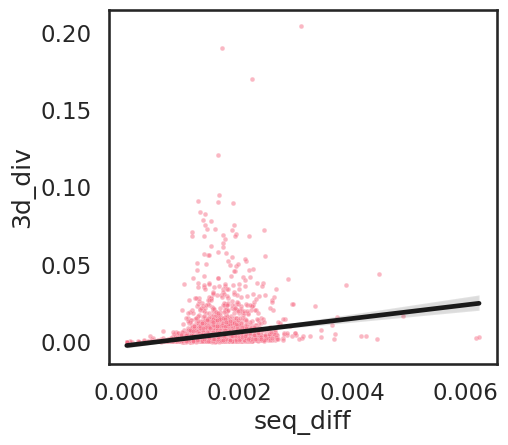

In [24]:
fig, ax = plt.subplots(figsize=(5,4.6))   
_ = sns.scatterplot(x='seq_diff', y='3d_div', data=all_indivs_avgs, s=12,alpha=0.5)
_ = sns.regplot(data=all_indivs_avgs, y="3d_div", x="seq_diff", scatter=False, ax=ax,color='k')

In [25]:
len(list(all_indivs_avgs.loc['chr1'].index))

418

In [26]:
chunks = dict.fromkeys(windows_to_keep.get_level_values(0).unique())

In [27]:
for chrm in chunks.keys():
    chunks[chrm] = list(all_indivs_avgs.loc[chrm].index)

In [88]:
DATA_PATH+'/reference'

'/wynton/group/capra/projects/modern_human_3Dgenome/data/reference'

In [90]:
import pickle

In [91]:
pickle.dump( chunks, open( "%s/reference/genome_chunks_dict.p" % DATA_PATH, "wb" ) )

# Workshopping the expected divergence code from Evonne

In [28]:
def find_inFileLoc(indiv, chrm):
    if indiv == 'hsmrca_ancestral':
        seq_dir = os.path.join(FASTA_PATH, "human_archaic_ancestor")
        file_path = os.path.join(seq_dir, ("human_archaic_ancestor_in_hg38_%s.fasta" % chrm))
    else:
        seq_dir = os.path.join(FASTA_PATH, "1KG")
        pop = indiv.split('_')[0]
        iid = indiv.split('_')[-1]
        file_path = os.path.join(seq_dir, ("%s/%s/%s_%s_hg38_full.fa" % (pop, indiv, chrm, iid)))
    return file_path

In [75]:
# Define variables to store individual IDs for ancestral and modern samples
anc_indiv = 'hsmrca_ancestral'
mod_indiv = 'AFR_ESN_female_HG03105'
chrm='chr20'

# Use the function find_inFileLoc to get the file path for the input files for the given chromosome
in_file_loc_anc_indiv = find_inFileLoc(anc_indiv, chrm)
in_file_loc_mod_indiv = find_inFileLoc(mod_indiv, chrm)

# Open the fasta files for the ancestral and modern individuals
anc_indiv_fasta_open = pysam.Fastafile(in_file_loc_anc_indiv)
mod_indiv_fasta_open = pysam.Fastafile(in_file_loc_mod_indiv)

# Create a new file to write the output to
f = open("%s_empiricDist_test.tsv" % chrm,"w")

for start_loc in chunks[chrm]:
    anc_indiv_seq = anc_indiv_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper()
    mod_indiv_seq = mod_indiv_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper()
    # Calculate the number of differences between the ancestral and modern sequences
    diff = [1 if anc != mod else 0 for anc,mod in zip(anc_indiv_seq,mod_indiv_seq)]
    diff_num = sum(diff)
    anc_pred  = runAkitaPreds(anc_indiv_seq)[:,:,0][0]
    
    diffs = dict()

    for i in range(len(anc_indiv_seq)):
        if diff[i] == 1: # make sure a difference is present
            if i == 0: # If the base is at the start of the sequence, the trinucleotide context is defined as the base itself and the following base
                if (anc_indiv_seq[i+1] == 'N'):
                    triNuc = anc_indiv_seq[i]
                else:
                    triNuc = "".join([anc_indiv_seq[i],anc_indiv_seq[i+1]])
            elif i == len(anc_indiv_seq)-1: #  # If the base is at the end of the sequence, the trinucleotide context is defined as the base itself and the preceding base
                if (anc_indiv_seq[i-1] == "N"):
                    triNuc = anc_indiv_seq[i]
                else:
                    triNuc = "".join([anc_indiv_seq[i-1],anc_indiv_seq[i]])
            else: # Otherwise, the trinucleotide context is defined as the three nucleotides immediately upstream and downstream of the base
                if (anc_indiv_seq[i-1] == 'N') and (anc_indiv_seq[i+1] == 'N'):
                    triNuc = anc_indiv_seq[i]
                elif (anc_indiv_seq[i-1] == 'N'):
                    triNuc = "".join([anc_indiv_seq[i],anc_indiv_seq[i+1]])
                elif (anc_indiv_seq[i+1] == 'N'):
                    triNuc = "".join([anc_indiv_seq[i-1],anc_indiv_seq[i]])
                else:
                    triNuc = "".join([anc_indiv_seq[i-1],anc_indiv_seq[i],anc_indiv_seq[i+1]])
                    
            # Add the archaic sequence at this position to the dictionary for this trinucleotide context
            if triNuc not in diffs:
                diffs[triNuc] = [mod_indiv_seq[i]]
            else:     # If the trinucleotide context is already in the dictionary, append the archaic sequence at this position to the list for this trinucleotide context
                diffs[triNuc].append(mod_indiv_seq[i])

    empirical_dist = []
    # Repeat the following process 100 times to create a null distribution of differences
    for iter in range(100): 
        print(iter,flush=True)
        # Create a randomly mutated version of the African individual
        random_mutated = anc_indiv_seq
        anc_ignore = anc_indiv_seq

        for k,v in diffs.items(): # For each of the differences
                indexes = [m.start() for m in re.finditer(k, anc_ignore)] #find the sequence
                indexes = random.sample(indexes,len(v)) #randomly sample
                for i in indexes:
                    anc_ignore = anc_ignore[:i+1] + "N" + anc_ignore[i+2:] # mask the original sequence with an N so it will not try to resample this part of the sequence
                for i,m in zip(indexes,v):
                    random_mutated = random_mutated[:i+1] + m + random_mutated[i+2:] # mutate trinucleotide in new posision
        
        random_pred  = runAkitaPreds(random_mutated)[:,:,0][0] #run akita on the shuffled sequence
        empirical_dist.append(1-stats.spearmanr(anc_pred, random_pred)[0]) # calculate the spearman on the shuffled sequence

run predictions
1/1 [==============================] - 1s 1s/step
0
run predictions
1/1 [==============================] - 1s 1s/step
1
run predictions
1/1 [==============================] - 1s 1s/step
2
run predictions
1/1 [==============================] - 1s 1s/step
3
run predictions
1/1 [==============================] - 1s 1s/step
4
run predictions
1/1 [==============================] - 1s 1s/step
5
run predictions
1/1 [==============================] - 1s 1s/step
6
run predictions
1/1 [==============================] - 1s 1s/step
7
run predictions
1/1 [==============================] - 1s 1s/step
8
run predictions
1/1 [==============================] - 1s 1s/step
9
run predictions
1/1 [==============================] - 1s 1s/step
10
run predictions
1/1 [==============================] - 1s 1s/step
11
run predictions
1/1 [==============================] - 1s 1s/step
12
run predictions
1/1 [==============================] - 1s 1s/step
13
run predictions
1/1 [=======================

KeyboardInterrupt: 

In [47]:
f.write(chrm + "\t" + str(start_loc) + "\t" + str(diff_num) + "\t" + "\t".join([str(x) for x in empirical_dist]) + "\n")
f.flush()
f.close()

In [76]:
# Define variables to store individual IDs for ancestral and modern samples
anc_indiv = 'hsmrca_ancestral'
mod_indiv = 'AFR_ESN_female_HG03105'
chrm='chr20'
start_loc = chunks[chrm][0]
# Use the function find_inFileLoc to get the file path for the input files for the given chromosome
in_file_loc_anc_indiv = find_inFileLoc(anc_indiv, chrm)
in_file_loc_mod_indiv = find_inFileLoc(mod_indiv, chrm)

# Open the fasta files for the ancestral and modern individuals
anc_indiv_fasta_open = pysam.Fastafile(in_file_loc_anc_indiv)
mod_indiv_fasta_open = pysam.Fastafile(in_file_loc_mod_indiv)

# Create a new file to write the output to
f = open("%s_empiricDist_test.tsv" % chrm,"w")

anc_indiv_seq = anc_indiv_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper()
mod_indiv_seq = mod_indiv_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper()
# Calculate the number of differences between the ancestral and modern sequences
diff = [1 if anc != mod else 0 for anc,mod in zip(anc_indiv_seq,mod_indiv_seq)]
diff_num = sum(diff)
anc_pred  = runAkitaPreds(anc_indiv_seq)[:,:,0][0]

diffs = dict()

for i in range(len(anc_indiv_seq)):
    if diff[i] == 1: # make sure a difference is present
        if i == 0: # If the base is at the start of the sequence, the trinucleotide context is defined as the base itself and the following base
            if (anc_indiv_seq[i+1] == 'N'):
                triNuc = anc_indiv_seq[i]
            else:
                triNuc = "".join([anc_indiv_seq[i],anc_indiv_seq[i+1]])
        elif i == len(anc_indiv_seq)-1: #  # If the base is at the end of the sequence, the trinucleotide context is defined as the base itself and the preceding base
            if (anc_indiv_seq[i-1] == "N"):
                triNuc = anc_indiv_seq[i]
            else:
                triNuc = "".join([anc_indiv_seq[i-1],anc_indiv_seq[i]])
        else: # Otherwise, the trinucleotide context is defined as the three nucleotides immediately upstream and downstream of the base
            if (anc_indiv_seq[i-1] == 'N') and (anc_indiv_seq[i+1] == 'N'):
                triNuc = anc_indiv_seq[i]
            elif (anc_indiv_seq[i-1] == 'N'):
                triNuc = "".join([anc_indiv_seq[i],anc_indiv_seq[i+1]])
            elif (anc_indiv_seq[i+1] == 'N'):
                triNuc = "".join([anc_indiv_seq[i-1],anc_indiv_seq[i]])
            else:
                triNuc = "".join([anc_indiv_seq[i-1],anc_indiv_seq[i],anc_indiv_seq[i+1]])
                
        # Add the archaic sequence at this position to the dictionary for this trinucleotide context
        if triNuc not in diffs:
            diffs[triNuc] = [mod_indiv_seq[i]]
        else:     # If the trinucleotide context is already in the dictionary, append the archaic sequence at this position to the list for this trinucleotide context
            diffs[triNuc].append(mod_indiv_seq[i])

empirical_dist = []
# Repeat the following process 100 times to create a null distribution of differences
for iter in range(100): 
    print(iter,flush=True)
    # Create a randomly mutated version of the African individual
    random_mutated = anc_indiv_seq
    anc_ignore = anc_indiv_seq

    for k,v in diffs.items(): # For each of the differences
            indexes = [m.start() for m in re.finditer(k, anc_ignore)] #find the sequence
            indexes = random.sample(indexes,len(v)) #randomly sample
            for i in indexes:
                anc_ignore = anc_ignore[:i+1] + "N" + anc_ignore[i+2:] # mask the original sequence with an N so it will not try to resample this part of the sequence
            for i,m in zip(indexes,v):
                random_mutated = random_mutated[:i+1] + m + random_mutated[i+2:] # mutate trinucleotide in new posision
    
    random_pred  = runAkitaPreds(random_mutated)[:,:,0][0] #run akita on the shuffled sequence
    empirical_dist.append(1-stats.spearmanr(anc_pred, random_pred)[0]) # calculate the spearman on the shuffled sequence

run predictions
1/1 [==============================] - 2s 2s/step
0
run predictions
1/1 [==============================] - 2s 2s/step
1
run predictions
1/1 [==============================] - 1s 1s/step
2
run predictions
1/1 [==============================] - 1s 1s/step
3
run predictions
1/1 [==============================] - 1s 1s/step
4
run predictions
1/1 [==============================] - 1s 1s/step
5
run predictions
1/1 [==============================] - 1s 1s/step
6
run predictions
1/1 [==============================] - 1s 1s/step
7
run predictions
1/1 [==============================] - 1s 1s/step
8
run predictions
1/1 [==============================] - 1s 1s/step
9
run predictions
1/1 [==============================] - 1s 1s/step
10
run predictions
1/1 [==============================] - 1s 1s/step
11
run predictions
1/1 [==============================] - 1s 1s/step
12
run predictions
1/1 [==============================] - 1s 1s/step
13
run predictions
1/1 [=======================

In [77]:
len(chunks['chr1'])

418

In [86]:
(418*5.5)/60

38.31666666666667

In [85]:
((len(windows_to_keep)*5.5)/60)/24

18.612152777777776

In [93]:
len(empirical_dist)

100

In [ ]:
# Define variables to store individual IDs for African and archaic samples
afr_indiv = 'AFR_ESN_female_HG03105'
arc_indiv = 'vindija'

# Use the function find_inFileLoc to get the file path for the input files for the given chromosome
in_file_loc_afr_indiv = find_inFileLoc(afr_indiv, chrm)
in_file_loc_arc_indiv = find_inFileLoc(arc_indiv, chrm)

# Open the fasta files for the African and archaic individuals
afr_indiv_fasta_open = pysam.Fastafile(in_file_loc_afr_indiv)
arc_indiv_fasta_open = pysam.Fastafile(in_file_loc_arc_indiv)

# Open the fasta file for the masked reference sequence
mask_fasta_open = pysam.Fastafile('/gpfs51/dors2/capra_lab/users/rinkerd/projects/3DNeand/data/genomes/masked_hg19_reference/%s_hg19_archaic.masked.fa' % chrm) #for the masked
# Open the fasta file for the unmasked reference sequence
human19_fasta_open = pysam.Fastafile('/dors/capra_lab/data/dna/human/hg19/%s.fa' % chrm)

# Create a new file to write the output to
f = open("%s_empiricDist.tsv3" % chrm,"w")

# Loop over the start locations in the chunks dictionary for the current chromosome (File is parallelized)
for start_loc in chunks[chrm]:
#for start_loc in [pos]:
#extract sequences
    # Get the sequences for the African and archaic individuals, masked reference sequence and reference sequence
    afr_indiv_seq = afr_indiv_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper()
    arc_indiv_seq = arc_indiv_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper()
    masked_seq = mask_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper() #for the masked 
    human19_seq = human19_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper()
    
    # Check if there are 'N's in the human19 sequence and skip to the next start location if there are
    if 'N' in human19_seq:
        print('Ns in %s:%s' % (chrm, start_loc),flush=True)
        continue
    
    # Create a masked sequence for the individual by replacing 'N's with 'N' and all other bases with the corresponding base
    afr_masked = "".join(["N" if m == "N" else "N" if afr == "N" else  "N" if arc == "N" else afr for m, afr, arc in zip(masked_seq, afr_indiv_seq, arc_indiv_seq)])
    arc_masked = "".join(["N" if m == "N" else "N" if afr == "N" else  "N" if arc == "N" else arc for m, afr, arc in zip(masked_seq, afr_indiv_seq, arc_indiv_seq)])
    
    # Calculate the number of differences between the African and archaic masked sequences
    diff = [1 if afr != arc else 0 for afr,arc in zip(afr_masked,arc_masked)]
    diff_num = sum(diff)
    
    
    # Create a filled sequence for the African individual by replacing 'N's with the corresponding base
    afr_filled = "".join([r if m == "N" else r if s == "N" else s for r, m, s in zip(human19_seq, masked_seq, afr_masked)])
    # Run akita prediction on filled sequence
    afr_pred  = runAkitaPreds(afr_filled)[:,:,0][0]

    diffs = dict()
    # Loop over each position in the masked sequences and store the differences between the African and archaic sequences that match the trinucleotide content
    for i in range(len(afr_masked)):
        if diff[i] == 1: # make sure a difference is present
            if i == 0: # If the base is at the start of the sequence, the trinucleotide context is defined as the base itself and the following base
                if (afr_masked[i+1] == 'N'):
                    triNuc = afr_masked[i]
                else:
                    triNuc = "".join([afr_masked[i],afr_masked[i+1]])
            elif i == len(afr_masked)-1: #  # If the base is at the end of the sequence, the trinucleotide context is defined as the base itself and the preceding base
                if (afr_masked[i-1] == "N"):
                    triNuc = afr_masked[i]
                else:
                    triNuc = "".join([afr_masked[i-1],afr_masked[i]])
            else:
                # Otherwise, the trinucleotide context is defined as the three nucleotides immediately upstream and downstream of the base
                if (afr_masked[i-1] == 'N') and (afr_masked[i+1] == 'N'):
                    triNuc = afr_masked[i]
                elif (afr_masked[i-1] == 'N'):
                    triNuc = "".join([afr_masked[i],afr_masked[i+1]])
                elif (afr_masked[i+1] == 'N'):
                    triNuc = "".join([afr_masked[i-1],afr_masked[i]])
                else:
                    triNuc = "".join([afr_masked[i-1],afr_masked[i],afr_masked[i+1]])
                    
            # Add the archaic sequence at this position to the dictionary for this trinucleotide context
            if triNuc not in diffs:
                diffs[triNuc] = [arc_masked[i]]
            else:     # If the trinucleotide context is already in the dictionary, append the archaic sequence at this position to the list for this trinucleotide context
                diffs[triNuc].append(arc_masked[i])

    empirical_dist = []
    # Repeat the following process 100 times to create a null distribution of differences
    for iter in range(100): 
        print(iter,flush=True)
        
        # Create a randomly mutated version of the African individual
        random_mutated_masked = afr_masked
        afr_masked_ignore = afr_masked

        for k,v in diffs.items(): # For each of the differences
            indexes = [m.start() for m in re.finditer(k, afr_masked_ignore)] #find the sequence
            indexes = random.sample(indexes,len(v)) #randomly sample
            for i in indexes:
                afr_masked_ignore = afr_masked_ignore[:i+1] + "N" + afr_masked_ignore[i+2:] # mask the original sequence with an N so it will not try to resample this part of the sequence
            for i,m in zip(indexes,v):
                random_mutated_masked = random_mutated_masked[:i+1] + m + random_mutated_masked[i+2:] # mutate trinucleotide in new posision

        random_mutated_filled = "".join([r if m == "N" else r if s == "N" else s for r, m, s in zip(human19_seq, masked_seq, random_mutated_masked)])
    
        random_pred  = runAkitaPreds(random_mutated_filled)[:,:,0][0] #run akita on the shuffled sequence
        empirical_dist.append(stats.spearmanr(afr_pred, random_pred)[0]) # calculate the spearman on the shuffled sequence
    f.write(chrm + "\t" + str(start_loc) + "\t" + str(diff_num) + "\t" + "\t".join([str(x) for x in empirical_dist]) + "\n")
    f.flush()
f.close()